![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+GenAI%2FEmbeddings&file=Vertex+AI+Text+Embeddings+API.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Embeddings/Vertex%20AI%20Text%20Embeddings%20API.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520GenAI%2FEmbeddings%2FVertex%2520AI%2520Text%2520Embeddings%2520API.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Embeddings/Vertex%20AI%20Text%20Embeddings%20API.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Embeddings/Vertex%20AI%20Text%20Embeddings%20API.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Vertex AI Text Embeddings API

Embeddings are condensed representations of data that retain the information from the data.  They are represented by a vector of numbers, usually floats, like `[0, 1, 0, 1]` or `[0.63475, 0.234, ..., 0.2646]`.  They are a trained/learned representation for data like text, images, and tables and served as preditions form these models. Based on the type of model that is used in training they can be very good at retaining latent information like semantic meaning in text, objects in images, and correlation in tables.

[Vertex AI APIs for embeddings](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings) provide simplified access to [Google's embedding models](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models#models) hosted on Vertex AI.

This workflow will show how to interact with the API for single, multiple, and large volumes of requests.

**References:**
- [Get text embeddings](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings)
- [Text embeddings API](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/text-embeddings-api)

Ready to use text embeddings in your applications?  Read more about [embeddings in this repository](./readme.md), including an overview of math with embeddings used for similarity: [The Math of Similarity](./The%20Math%20of%20Similarity.ipynb)

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.66.0'),
    ('google.cloud.storage', 'google-cloud-storage'),
    ('google.cloud.bigquery', 'google-cloud-bigquery')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [9]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [10]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'embeddings-api'

# Set the BUCKET name for saving work:
BUCKET = PROJECT_ID

# Set BigQuery Names
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT

packages:

In [33]:
import os
import asyncio
import matplotlib.pyplot as plt

from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage
import vertexai.language_models # for text embedding models

In [15]:
aiplatform.__version__

'1.66.0'

clients:

In [16]:
vertexai.init(project = PROJECT_ID, location = REGION)
gcs = storage.Client(project = PROJECT_ID)
bq = bigquery.Client(project = PROJECT_ID)

bucket = gcs.lookup_bucket(BUCKET)

---
## Text For Examples

This repository contains a section for document processing (chunking) that includes an example of processing a PDF with the Document AI Layout Parser.  The chunks of text from that project are stored with this repository and loaded for use in this example.  The following code will load the text from the local drive and if it is missing it will first download it from the repository on GitHub.

---
## Select And Setup Embedding Model

Select one of the [supported text embedding models](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings#supported-models).  In this case `text-embedding-004` is used.

In [23]:
embedder = vertexai.language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')

## Embedding Request: Simple

In [25]:
response = embedder.get_embeddings(['Example text'])

In [29]:
response[0].values[0:10]

[-0.023280976340174675,
 0.040125321596860886,
 -0.05239994078874588,
 0.02302161045372486,
 0.03951878473162651,
 0.03573915734887123,
 0.013259540311992168,
 0.02080409973859787,
 -0.0025817425921559334,
 -0.011102449148893356]

In [45]:
len(response[0].values)

768

In [32]:
response[0].statistics

TextEmbeddingStatistics(token_count=2.0, truncated=False)

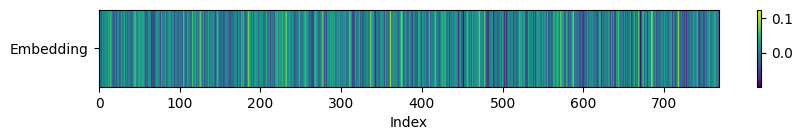

In [44]:
plt.figure(figsize=(10, 1))
plt.imshow([response[0].values], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0], ["Embedding"]) 
plt.colorbar()
plt.show()

TODO:
- pick a model
- make a request
- examine the response
    - shape
    - visualize
    - check norm
- make a request for multiple texts
- make a request async
- type of task
    - retrieve all
    - compare and visualize
    - check norms
- batch request with gcs
- batch request with BQ
- scaling async request
